<a href="https://colab.research.google.com/github/Maruf1904002/Brainwave_Matrix_Intern-Credit_Card_Fraud_Detection/blob/main/Credit_Card_Fraud_Detection_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

This notebook downloads the **ULB Credit Card Fraud Detection** dataset from Kaggle via API token, preprocesses the data (standardizes Amount/Time), trains a **LightGBM** classifier with class-weighting to handle class imbalance, and evaluates performance using **accuracy, precision, recall, F1-score, ROC–AUC, PR–AUC**, plus **ROC/PR curves** and a **confusion matrix**.


## Step 1: Install dependencies

In [1]:
!pip -q install kaggle lightgbm imbalanced-learn

## Step 2: Kaggle API token

In [2]:
import os, json
from google.colab import files

# Upload kaggle.json
print("Upload kaggle.json (Kaggle API token)")
uploaded = files.upload()  # Choose kaggle.json

# Save to the right place with proper permissions
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
if 'kaggle.json' in uploaded:
    with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'wb') as f:
        f.write(uploaded['kaggle.json'])
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
    print("Kaggle token set up at ~/.kaggle/kaggle.json")
else:
    raise FileNotFoundError("kaggle.json not uploaded. Please re-run and upload.")


Upload kaggle.json (Kaggle API token)


Saving kaggle.json to kaggle.json
Kaggle token set up at ~/.kaggle/kaggle.json


## Step 3: Download dataset from Kaggle

In [3]:
# Create data directory & download
DATA_DIR = "/content/data/ccfraud"
os.makedirs(DATA_DIR, exist_ok=True)

# Download the ULB credit card fraud dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud -p $DATA_DIR
# Unzip
!unzip -o -q $DATA_DIR/*.zip -d $DATA_DIR

import pandas as pd, numpy as np
import os

csv_path = os.path.join(DATA_DIR, "creditcard.csv")
assert os.path.exists(csv_path), "creditcard.csv not found after unzip"
df = pd.read_csv(csv_path)
print(df.shape)
df.head()


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 969MB/s]
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Step 4: Basic EDA & Class Imbalance

In [4]:
df['Class'].value_counts(normalize=True).rename({0:'Legit',1:'Fraud'}).to_frame('proportion')

,proportion
Class,
Legit,0.998273
Fraud,0.001727


## Step 5: Preprocessing & Split


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_prep = df.copy()
for col in ['Amount','Time']:
    if col in df_prep.columns:
        scaler = StandardScaler()
        df_prep[col] = scaler.fit_transform(df_prep[[col]])

X = df_prep.drop(columns=['Class'])
y = df_prep['Class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((227845, 30),
 (56962, 30),
 np.float64(0.001729245759178389),
 np.float64(0.0017204452090867595))

## Step 6: Train a LightGBM classifier (with class weights)

In [6]:
import numpy as np
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0,1])
w = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_map = {int(c): float(wi) for c, wi in zip(classes, w)}
class_weight_map


{0: 0.5008661206149896, 1: 289.14340101522845}

In [7]:
clf = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.02,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=1e-3,
    reg_lambda=1e-3,
    random_state=42,
    class_weight=class_weight_map
)

clf.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight={0: 0.5008661206149896, 1: 289.14340101522845},
               colsample_bytree=0.9, learning_rate=0.02, n_estimators=600,
               random_state=42, reg_alpha=0.001, reg_lambda=0.001,
               subsample=0.9)

## Step 7: Evaluate — Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix

In [8]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# Predict probabilities & labels (threshold 0.5)
proba = clf.predict_proba(X_test)[:,1]
y_pred = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))


Accuracy : 0.9995
Precision: 0.8469
Recall   : 0.8469
F1-score : 0.8469
ROC-AUC  : 0.9789
Confusion Matrix:
 [[56849    15]
 [   15    83]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8469    0.8469    0.8469        98

    accuracy                         0.9995     56962
   macro avg     0.9233    0.9233    0.9233     56962
weighted avg     0.9995    0.9995    0.9995     56962



### ROC Curve

ROC-AUC: 0.9789
PR-AUC (Average Precision): 0.8776
Best-F1 threshold on this set: 0.9226,  F1=0.8710, P=0.9205, R=0.8265


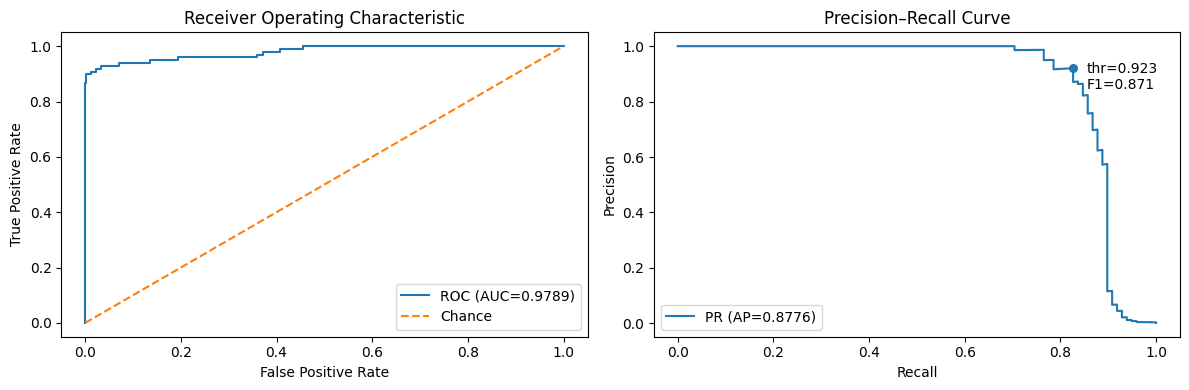

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Scores
roc = roc_auc_score(y_test, proba)
ap  = average_precision_score(y_test, proba)   # PR-AUC
print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC (Average Precision): {ap:.4f}")

# Curves data
fpr, tpr, _ = roc_curve(y_test, proba)
prec, rec, thr = precision_recall_curve(y_test, proba)

# Best-F1 point
f1s = 2*prec*rec/(prec+rec+1e-9)
best_i = int(np.argmax(f1s))
best_thr = thr[best_i] if best_i < len(thr) else 0.5
print(f"Best-F1 threshold on this set: {best_thr:.4f},  F1={f1s[best_i]:.4f}, "
      f"P={prec[best_i]:.4f}, R={rec[best_i]:.4f}")
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# ROC (left)
axs[0].plot(fpr, tpr, label=f'ROC (AUC={roc:.4f})')
axs[0].plot([0, 1], [0, 1], '--', label='Chance')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend()

# PR (right)
axs[1].plot(rec, prec, label=f'PR (AP={ap:.4f})')
axs[1].scatter(rec[best_i], prec[best_i], s=30)  # mark best-F1
axs[1].annotate(f"thr={best_thr:.3f}\nF1={f1s[best_i]:.3f}",
                (rec[best_i], prec[best_i]),
                textcoords="offset points", xytext=(10, -15))
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision–Recall Curve')
axs[1].legend()

plt.tight_layout()
plt.show()


## Step 8: Threshold tuning by F1


Computed cm_b at best-F1 threshold = 0.9226


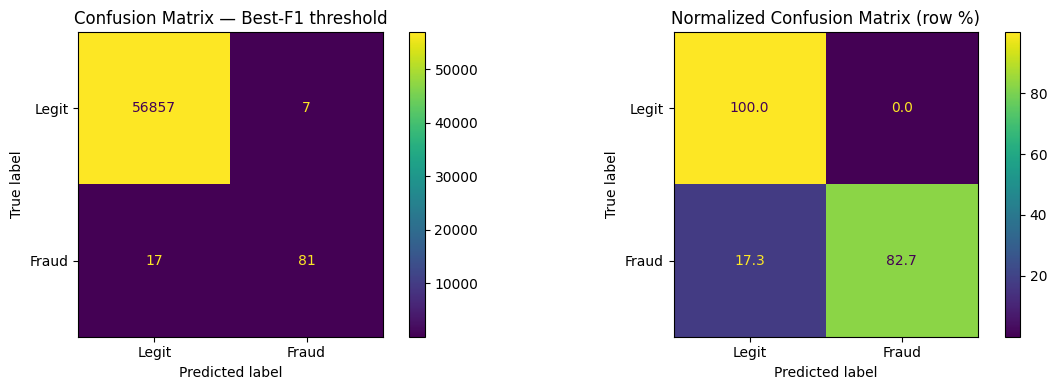

In [15]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# Ensure probabilities
try:
    proba
except NameError:
    proba = clf.predict_proba(X_test)[:, 1]

# Recompute cm_b at best-F1 threshold if not present
try:
    cm_b
except NameError:
    P, R, thr = precision_recall_curve(y_test, proba)
    f1s = 2*P*R/(P+R+1e-9)
    best_i = int(np.argmax(f1s))
    best_thr = thr[best_i] if best_i < len(thr) else 0.5
    y_pred_best = (proba >= best_thr).astype(int)
    cm_b = confusion_matrix(y_test, y_pred_best)
    print(f"Computed cm_b at best-F1 threshold = {best_thr:.4f}")

# counts and row-normalized (%)
cm_counts = cm_b
cm_norm = (cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)) * 100.0

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left: counts
ConfusionMatrixDisplay(cm_counts, display_labels=['Legit','Fraud']).plot(
    ax=axs[0], values_format='d'
)
axs[0].set_title('Confusion Matrix — Best-F1 threshold')
axs[0].grid(False)

# Right: row-normalized (%)
ConfusionMatrixDisplay(cm_norm, display_labels=['Legit','Fraud']).plot(
    ax=axs[1], values_format='.1f'
)
axs[1].set_title('Normalized Confusion Matrix (row %)')
axs[1].grid(False)

plt.tight_layout()
plt.show()
